In [192]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
colors = {
    "black": 1,
    "red": 5,
    "green": 3,
    "yellow": 4,
    "blue": 2,
    "nothing": 0,
    "white": 6
}

In [3]:
y = pd.DataFrame()
y["col"] = []
read_in_cols = []
for i, (k, v) in enumerate(colors.items()):
    read_in_cols.append(pd.read_csv(f"{k}.rtf"))
    read_in_cols[i]["col"] = [v] * len(read_in_cols[i])
    
colors_dataset = pd.concat(read_in_cols)

colors_dataset.head()

,r,g,b,h,s,v,col
0,21,21,22,240.0,0.0455,22,1
1,21,21,22,240.0,0.0455,22,1
2,21,21,22,240.0,0.0455,22,1
3,21,21,22,240.0,0.0455,22,1
4,21,21,22,240.0,0.0455,22,1


In [4]:
colors_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9600 entries, 0 to 1325
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   r       9600 non-null   int64  
 1    g      9600 non-null   int64  
 2    b      9600 non-null   int64  
 3    h      9600 non-null   float64
 4    s      9600 non-null   float64
 5    v      9600 non-null   int64  
 6   col     9600 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 600.0 KB


In [5]:
import sklearn

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate
# from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, classification_report
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
# from sklearn.pipeline import Pipeline, make_pipeline

# Models
# from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import LinearSVC, SVC
# from sklearn.neural_network import MLPClassifier

# IMBLEARN
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import make_pipeline

In [6]:
df = colors_dataset
eda_df = df.copy()

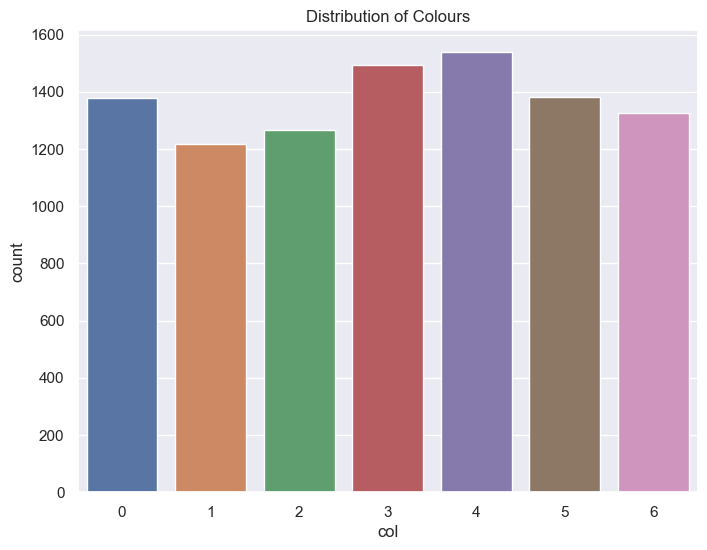

In [7]:
sns.set()

# Distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='col', data=eda_df)
plt.title('Distribution of Colours')
plt.show()

In [80]:
X = df.drop(columns=["r", " g", " b", "col"])
# X = df.drop(columns=["col"])
y = df["col"]


In [81]:
X["vs"] = [v*s for v, s in zip(X[" v"], X[" s"])]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [243]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [244]:
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

In [245]:
# predictions = clf.predict(X_test)

# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: {:.2f}%".format(accuracy * 100))

# print("Classification Report:")
# print(classification_report(y_test, predictions))

In [187]:
from sklearn.model_selection import cross_val_score

# Define the cross-validation strategy (Stratified K-Folds in this case)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(dtc, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy: {:.2f}%".format(cv_scores.mean() * 100))


Cross-Validation Scores: [0.959375   0.95572917 0.96041667 0.96145833 0.96197917]
Mean Accuracy: 95.98%


In [188]:
dtc

DecisionTreeClassifier(max_depth=10)

In [92]:
from sklearn.tree import export_text

# Assuming you have already trained a decision tree classifier (clf) on your data
# For example:

# Print out the decision tree rules
tree_rules = export_text(dtc, feature_names=list(X.columns))  # feature_names is a list of feature names (optional)
print(tree_rules)

|---  h <= 79.64
|   |---  s <= 0.33
|   |   |---  v <= 12.50
|   |   |   |--- class: 0
|   |   |---  v >  12.50
|   |   |   |---  v <= 47.50
|   |   |   |   |--- class: 6
|   |   |   |---  v >  47.50
|   |   |   |   |--- class: 6
|   |---  s >  0.33
|   |   |---  h <= 34.70
|   |   |   |---  v <= 13.00
|   |   |   |   |--- class: 0
|   |   |   |---  v >  13.00
|   |   |   |   |--- class: 5
|   |   |---  h >  34.70
|   |   |   |---  h <= 38.89
|   |   |   |   |--- class: 4
|   |   |   |---  h >  38.89
|   |   |   |   |--- class: 4
|---  h >  79.64
|   |--- vs <= 4.50
|   |   |---  v <= 5.50
|   |   |   |---  s <= 0.29
|   |   |   |   |--- class: 0
|   |   |   |---  s >  0.29
|   |   |   |   |--- class: 0
|   |   |---  v >  5.50
|   |   |   |---  h <= 215.00
|   |   |   |   |--- class: 1
|   |   |   |---  h >  215.00
|   |   |   |   |--- class: 0
|   |--- vs >  4.50
|   |   |---  h <= 200.00
|   |   |   |---  s <= 0.17
|   |   |   |   |--- class: 6
|   |   |   |---  s >  0.17
|   |   | 

In [218]:
def tree_to_array(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    tree_array = [-1]*2**(dtc.get_params()['max_depth']+1)
    def dtc_treeing(node, index):
#         print(node)
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            match name:
                case "vs":
                    extra = 6000
                case "h":
                    extra = 7000
                case "s":
                    extra = 8000
                case "v":
                    extra = 9000
                case _:
                    extra = 0
            threshold = tree_.threshold[node]
            value = threshold + extra
            tree_array[index] = value
            dtc_treeing(tree_.children_left[node], index*2+1)
            dtc_treeing(tree_.children_right[node], index*2)
        else:
            tree_array[index] = tree_.value[node].argmax() + 5000
    dtc_treeing(0, 1)
    return tree_array
#     print(f"def tree({', '.join(feature_names)}):")
# tree_ = dtc.tree_

# tree_.value[0].argmax()

In [229]:
def DTC_Compare(node_value, h, s, v):
    vs = v*s
    res = False
    to_compare = 0
    extra = 0
    if node_value >= 6000:
        to_compare = vs
        extra = 6000
    if node_value >= 7000:
        to_compare = h
        extra = 7000
    if node_value >= 8000:
        to_compare = s
        extra = 8000
    if node_value >= 9000:
        to_compare = v
        extra = 9000
    res = to_compare < (node_value-extra)
            
    if node_value >= 5000 and node_value <= 5006:
        return (res, node_value - 5000)
    else:
        return (res, -1)
    
def DTC_Colores(h, s, v):
    position = 1
    tree_array[-1] = 0
    while True:
        node_value = tree_array[position]
        if node_value == 0:
            break
        else:
            (res, col) = DTC_Compare(node_value, h, s, v)
            if col != -1:
                break
#             print(position)
            position = position * 2 + (1 if res else 0)
    return col

In [247]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)

# Define the cross-validation strategy (Stratified K-Folds)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV object with F1 scoring, stratified k-fold cross-validation, and the parameter grid
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, scoring='f1_macro', cv=stratified_kfold)

# Perform the grid search on the data
grid_search.fit(X, y)

# Print the best parameters and corresponding F1 score
print("Best Parameters: ", grid_search.best_params_)
print("Best F1 Score: {:.2f}".format(grid_search.best_score_))


Best Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best F1 Score: 0.96


In [249]:
dtc = DecisionTreeClassifier(**{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}, random_state=42)
dtc.fit(X_train, y_train)

predictions = dtc.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

print("Classification Report:")
print(classification_report(y_test, predictions))

tree_array = tree_to_array(dtc, ['h', 's', 'v', 'vs'])

st = time.time()

print(DTC_Colores(60, 0.1294, 255 ) == 6)
print(DTC_Colores(42.2581, 0.7949, 234) == 4)
print(DTC_Colores(4.2857, 0.56, 100 ) == 5)
print(DTC_Colores(240, 0.25, 4) == 0)
print(DTC_Colores(220.5882, 0.8718, 39 ) == 2)
print(DTC_Colores(192, 0.3846, 13) == 3)
print(DTC_Colores(141.5385, 0.4432, 88) == 3)
print(DTC_Colores(200, 0.1364, 22 ) == 1)
print(DTC_Colores(52.1739, 0.1729, 133 ) == 6)
print(DTC_Colores(45.7143, 0.2165, 97 ) == 6)
print(DTC_Colores(47.3684, 0.2184, 87 ) == 6)
print(DTC_Colores(56.8421, 0.2235, 170 ) == 6)
print(DTC_Colores(57.8571, 0.2044, 137 ) == 6)
print(DTC_Colores(64.0909, 0.2222, 198 ) == 6)
print(DTC_Colores(36, 0.1111, 45 ) == 6)
print(DTC_Colores(60, 0.0513, 39 ) == 6)
print(DTC_Colores(153.75, 0.2712, 59 ) == 3)
print(DTC_Colores(142.1053, 0.2676, 71 ) == 3)
print(DTC_Colores(147.1698, 0.8154, 65 ) == 3)
print(DTC_Colores(165, 0.2105, 19) == 3)
print(DTC_Colores(147.5, 0.8, 30 ) == 3)
print(DTC_Colores(147.8571, 0.8235, 34 ) == 3)
print(DTC_Colores(148.2353, 0.7391, 23 ) == 3)
print(DTC_Colores(148.4211, 0.7917, 24 ) == 3)
print(DTC_Colores(200, 0.6, 5 ) == 0)
print(DTC_Colores(240, 0.3333, 3 ) == 0)
print(DTC_Colores(180, 1, 1 ) == 0)
print(DTC_Colores(210, 0.6667, 3 ) == 0)
print(DTC_Colores(180, 0.5, 2 ) == 0)
print(DTC_Colores(195, 0.6667, 6 ) == 0)
print(DTC_Colores(240, 0.3333, 3 ) == 0)




et = time.time()

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Accuracy: 96.20%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       275
           1       0.90      0.87      0.88       247
           2       0.99      1.00      0.99       258
           3       0.98      0.99      0.98       297
           4       0.98      0.98      0.98       311
           5       0.98      0.98      0.98       277
           6       0.97      0.99      0.98       255

    accuracy                           0.96      1920
   macro avg       0.96      0.96      0.96      1920
weighted avg       0.96      0.96      0.96      1920

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
Execution time: 0.0009992122650146484 seconds


In [246]:
with open('dtc.rtf', 'w') as file:
    # Write list elements to the file
    for item in tree_array:
        file.write(str(item) + '\n')  # Writes each item on a new line

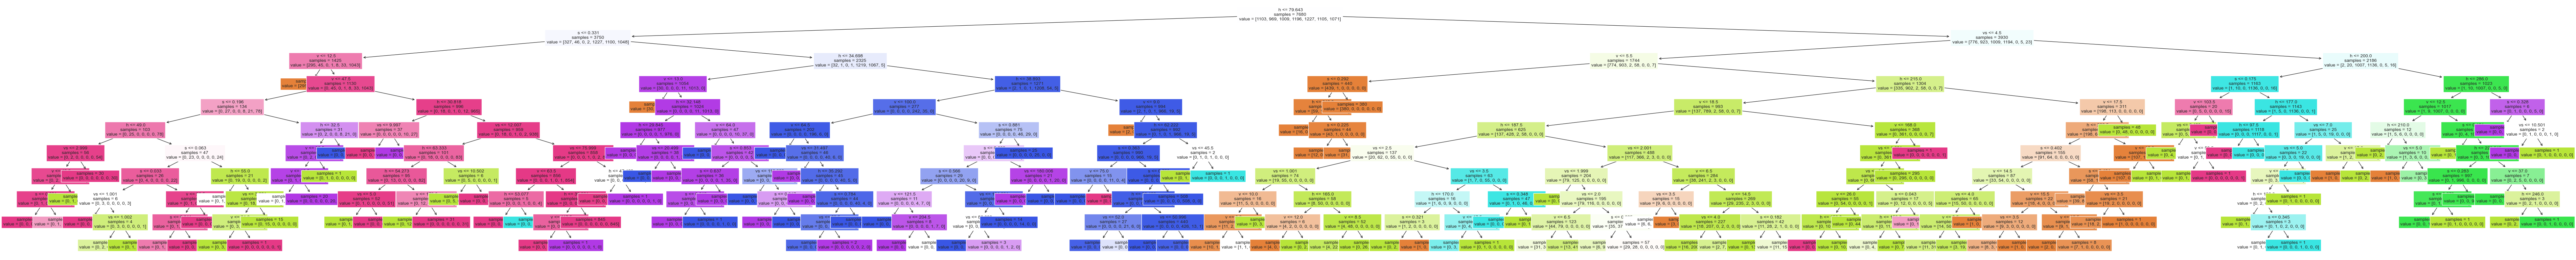

In [242]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(100, 10))
plot_tree(
    dtc,
    feature_names=X.columns,
    impurity=False,
    filled=True,
    ax=ax,
    fontsize=10,
)
plt.show()